# Real vs AI-Generated Image Classifier

This notebook implements a CNN model to classify between real and AI-generated images using the CIFAKE dataset.

In [22]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

In [23]:
# Configuration parameters
IMG_SIZE = 32  # Images in CIFAKE are 32x32
BATCH_SIZE = 62
EPOCHS = 16
NUM_CLASSES = 2  # Real (0) and Fake (1)

# Set random seed for reproducibility
tf.random.set_seed(42)

In [24]:
# Download the dataset
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

def load_and_preprocess_data(base_path, subset='train'):
    """
    Load and preprocess images from the given directory.
    Args:
        base_path: Base path to the dataset
        subset: Either 'train' or 'test'
    Returns:
        images and their corresponding labels
    """
    images = []
    labels = []

    # Load real images
    real_dir = os.path.join(base_path, f'{subset}/REAL')
    for img_name in os.listdir(real_dir):
        img_path = os.path.join(real_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            images.append(img)
            labels.append(0)  # 0 for real images

    # Load AI-generated (fake) images
    fake_dir = os.path.join(base_path, f'{subset}/FAKE')
    for img_name in os.listdir(fake_dir):
        img_path = os.path.join(fake_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            images.append(img)
            labels.append(1)  # 1 for fake images

    return np.array(images), np.array(labels)



Loading and preprocessing training data...
Loading and preprocessing test data...


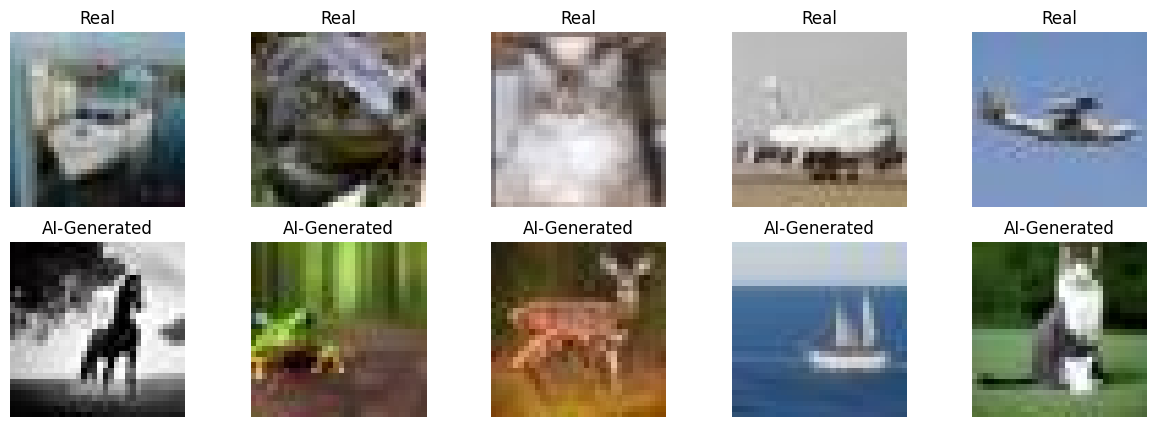

In [25]:

# Load training and test data separately
print("Loading and preprocessing training data...")
X_train, y_train = load_and_preprocess_data(path, subset='train')

print("Loading and preprocessing test data...")
X_test, y_test = load_and_preprocess_data(path, subset='test')

# Normalize pixel values
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Display some sample images
plt.figure(figsize=(15, 5))
for i in range(5):
    # Plot real images
    plt.subplot(2, 5, i + 1)
    real_idx = np.where(y_train == 0)[0][i]
    plt.imshow(X_train[real_idx])
    plt.title('Real')
    plt.axis('off')

    # Plot fake images
    plt.subplot(2, 5, i + 6)
    fake_idx = np.where(y_train == 1)[0][i]
    plt.imshow(X_train[fake_idx])
    plt.title('AI-Generated')
    plt.axis('off')
plt.show()

In [26]:
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (100000, 32, 32, 3)
Testing set shape: (20000, 32, 32, 3)


In [27]:
def create_model():
    """
    Create and return the CNN model architecture.
    This is a simple but effective CNN architecture for image classification.
    """
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Flatten and Dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

# Create and compile the model
model = create_model()
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 13, 13, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 160,066 (625.26 KB)

 Trainable params: 159,618 (623.51 KB)

 Non-trainable params: 448 (1.75 KB)

In [28]:
# Define callbacks
callbacks = [
    ModelCheckpoint(
        'best_model.h5',
        save_best_only=True,
        monitor='val_accuracy'
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
]

# Train the model
print("Training model...")
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    callbacks=callbacks
)

Training model...
Epoch 1/16
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8258 - loss: 0.4187

1291/1291 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.8258 - loss: 0.4186 - val_accuracy: 0.9495 - val_loss: 0.1421
Epoch 2/16
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9077 - loss: 0.2327 - val_accuracy: 0.7818 - val_loss: 0.5331
Epoch 3/16
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9224 - loss: 0.1947 - val_accuracy: 0.8214 - val_loss: 0.4387
Epoch 4/16
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9334 - loss: 0.1688 - val_accuracy: 0.5767 - val_loss: 1.5059
Epoch 5/16
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9426 - loss: 0.1462 - val_accuracy: 0.8936 - val_loss: 0.2918
Epoch 6/16
1291/1291 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9503 - loss: 0.1276 - val_accuracy: 0.9464 - val_loss: 0.1525


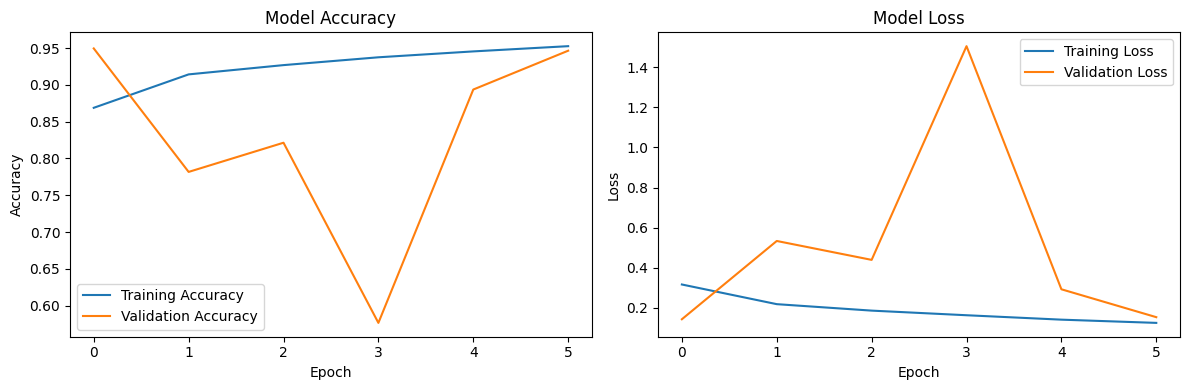

In [29]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Evaluating model...
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8398 - loss: 0.3688
Test accuracy: 0.8834
Test loss: 0.2794
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


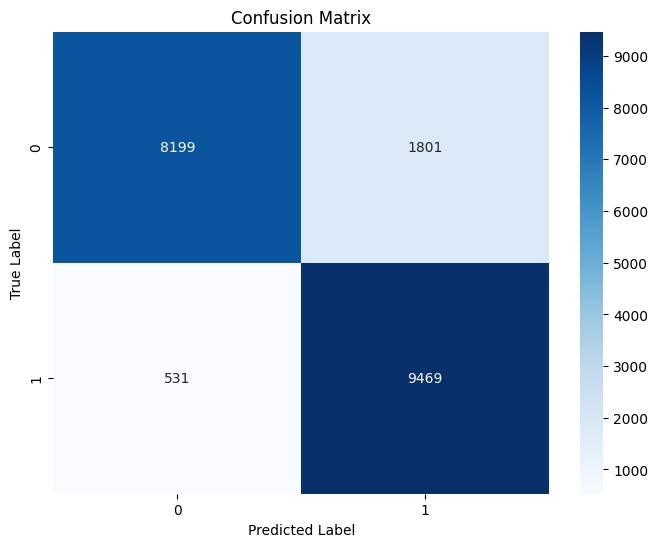

In [30]:
# Evaluate the model
print("Evaluating model...")
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Make predictions on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Plot confusion matrix
cm = tf.math.confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

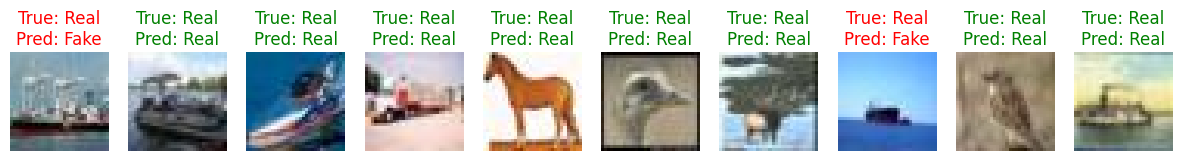

In [31]:
# Display some predictions
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_test[i])
    true_label = 'Real' if y_test[i] == 0 else 'Fake'
    pred_label = 'Real' if y_pred_classes[i] == 0 else 'Fake'
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f'True: {true_label}\nPred: {pred_label}', color=color)
    plt.axis('off')
plt.show()